## Подключение всех необходимых библиотек

In [2]:
import librosa
import tqdm
import os

import numpy as np
import pandas as pd

from torch import nn
from torch.functional import F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Hyperparameters

In [12]:
N_MFCCS = 25

# Обработка аудио файлов и создание csv файла (датасета) с признаками

In [19]:
#header = 'chroma_stft rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
header = ''
for i in range(N_MFCCS):
    header += f' mfcc{i}'
header = header.lstrip()
header

'mfcc0 mfcc1 mfcc2 mfcc3 mfcc4 mfcc5 mfcc6 mfcc7 mfcc8 mfcc9 mfcc10 mfcc11 mfcc12 mfcc13 mfcc14 mfcc15 mfcc16 mfcc17 mfcc18 mfcc19 mfcc20 mfcc21 mfcc22 mfcc23 mfcc24'

## 1. Заполнение csv файла данными

In [22]:
# Функция для извлечения признаков
def extract_features(folder, filename):
    songname = os.path.join(folder, filename)
    y, sr = librosa.load(songname, mono=True)
    # rms = librosa.feature.rms(y=y)
    # chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    # spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    # spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    # rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    # zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCCS)

    # feature_row_data = [np.mean(chroma_stft), np.mean(rms), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)]
    feature_row_data = []
    for e in mfcc:
        feature_row_data.append(np.mean(e))

    feature_row_data.append(folder == 'burr_audio')
    return feature_row_data

In [23]:
count = 0
if not os.path.exists('train_dataset.csv') or \
    pd.read_csv('train_dataset.csv').shape[1] - (6 + 1 + 1) != N_MFCCS: # other features + name + label
    columns = (header + " label").split()
    features = pd.DataFrame(columns=columns)
    for folder in ['burr_audio', 'normal_audio']:
        for filename in tqdm.tqdm(os.listdir(folder), desc=folder):
            try:
                features.loc[filename] = pd.Series(extract_features(folder, filename), index=columns)
            except Exception as k:
                count += 1
    features.to_csv('train_dataset.csv')

burr_audio:   0%|          | 30/7818 [00:02<06:38, 19.53it/s] /Users/jafarkor/GitHub/ai-challenge-anticartavost-/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
burr_audio:   1%|          | 93/7818 [00:02<01:44, 74.07it/s]/Users/jafarkor/GitHub/ai-challenge-anticartavost-/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
burr_audio:   5%|▌         | 415/7818 [00:03<00:24, 306.87it/s]/Users/jafarkor/GitHub/ai-challenge-anticartavost-/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
burr_audio:   7%|▋         | 582/7818 [00:03<00:22, 321.98it/s]/Users/jafarkor/GitHub/ai-challenge-anticartavost-/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for i

In [24]:
print(count)

0


## Обработка датасета и разделение на тренировочную и тестовую выборки

In [25]:
df = pd.read_csv("train_dataset.csv", index_col=0)
X = df.drop(columns=["label"])
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Масштабирование признаков

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
"""pca = PCA(n_components=9)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)"""

'pca = PCA(n_components=9)\nX_train = pca.fit_transform(X_train)\nX_test = pca.transform(X_test)'

In [28]:
import torch.utils
import torch.utils.data


class MyDataset(torch.utils.data.Dataset):

    def __init__(self, features, labels, device=torch.device("cpu")):
        self.features = torch.tensor(features, dtype = torch.float32).to(device)
        self.labels = torch.tensor(labels, dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, ind):
        return self.features[ind], self.labels[ind]

In [29]:
import torch.utils
import torch.utils.data
import torch.nn.functional

device = torch.device("mps")
train_dataset = MyDataset(X_train, y_train, device)
test_dataset = MyDataset(X_test, y_test, device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

/var/folders/2z/1mq4rcvj0f75_rlwvf4546gc0000gn/T/ipykernel_37831/3082938681.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.labels = torch.tensor(labels, dtype = torch.float32).to(device)


## Архитектура нашей нейронной сети и ее обучение

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

class RecognizeNet(nn.Module):
    def __init__(self):
        super(RecognizeNet, self).__init__()
        self.layer1 = nn.Linear(N_MFCCS, 100)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)  # Dropout для первого слоя

        self.layer2 = nn.Linear(100, 200)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)  # Dropout для второго слоя

        self.layer3 = nn.Linear(200, 100)
        self.act3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)  # Dropout для третьего слоя

        self.layer4 = nn.Linear(100, 50)
        self.act4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)  # Dropout для четвертого слоя

        self.layer5 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)
        x = self.dropout2(x)

        x = self.layer3(x)
        x = self.act3(x)
        x = self.dropout3(x)

        x = self.layer4(x)
        x = self.act4(x)
        x = self.dropout4(x)

        x = self.layer5(x)
        x = self.sigmoid(x)
        return x

In [46]:
model = RecognizeNet()
lr = 0.001
model.to(device)
criterion = nn.BCELoss()  # Предполагаем, что решаем задачу бинарной классификации
optimizer = optim.Adam(model.parameters(), lr=lr)

total_epochs = 0
total_step = len(train_loader)

loss_fn = nn.BCELoss()
metric_list = []

In [47]:
epochs = 300
pbar = tqdm.tqdm(range(epochs))
train_losses = []
val_losses = []

for epoch in pbar:
    model.train()
    train_loss = 0
    for i, batch in enumerate(train_loader):
        x, y = batch
        preds = model(x).squeeze()
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total = y.size(0)
        predicted = (torch.flatten((preds.data > 0.5)))
        correct = (predicted == y).sum().item()
        metric_list.append(f1_score(y.cpu(), predicted.cpu()))
        train_loss += f1_score(y.cpu(), predicted.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    total_epochs += 1
    if (epoch + 1) % 10 == 0:
        pbar.set_description('Epoch [{}/{}], Loss: {:.4f}, F1_score: {:.2f}%'
                .format(total_epochs, (total_epochs // epochs + 1) * epochs, loss.item(),
                        sum(metric_list) / len(metric_list)))
    # Проверка на валидационной выборке

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            preds = model(x).squeeze()
            predicted = (torch.flatten((preds.data > 0.5)))
            val_loss += f1_score(y.cpu(), predicted.cpu())

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

Epoch [300/600], Loss: 0.3506, F1_score: 0.64%: 100%|██████████| 300/300 [04:02<00:00,  1.23it/s]


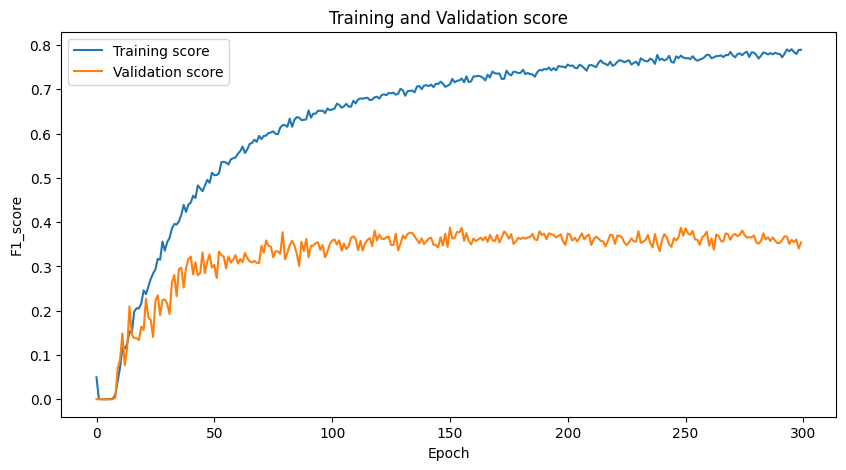

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training score')
plt.plot(val_losses, label='Validation score')
plt.xlabel('Epoch')
plt.ylabel('F1_score')
plt.title('Training and Validation score')
plt.legend()
plt.show()

## Тестирование нашей нейронки

In [39]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for x, y in test_loader:
        y_pred = model(x)
        predicted = (torch.flatten(y_pred.data > 0.5))
        # total += y.size(0)
        # correct += (predicted == y).sum().item()
        break

    print('Test F1_score of the model on the test data: {} %'.format(f1_score(y.cpu(), predicted.cpu())))

Test F1_score of the model on the test data: 0.2318840579710145 %


# Submission

In [8]:
data_scoring = pd.read_csv("test_dataset.csv", index_col=0)
sample_submission = pd.read_csv("test.csv", header=None)
sample_submission.columns = ['Filename', 'Label']


model.eval()
with torch.no_grad():
    results = model(torch.FloatTensor(data_scoring.values).to(device)).cpu().squeeze()


submission = pd.DataFrame({"Filename": data_scoring.index, "Label": pd.Series(results).astype(int)})
submission = submission.sort_values(by="Filename")
#ВСЕ ОК)))

sample_submission = sample_submission.sort_values(by="Filename")
sample_submission["Label"] = submission["Label"]
sample_submission = sample_submission.sort_index()


sample_submission.to_csv("submission.csv", index=False, header=False)

NameError: name 'model' is not defined